# $B_z$ extraction is simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from scipy import optimize
sys.path.append("../CommonUtils/") # https://github.com/glukicov/EDMTracking/blob/master/CommonUtils/CommonUtils.py
import CommonUtils as cu

### Define constants and starting fit parameters

In [2]:
font_size=14 # for plots 

t_min = 0 # us  #TODO 30 for data 
t_max = 100 # us 
print("Starting and end times:", t_min, "to", t_max, "us")
p_min = 1800 # MeV 
p_max = 3100 # MeV 
print("Momentum cuts:", p_min, "to", p_max, "MeV")

omega_a = 1.43934 # MHz (magic)
cu._omega=omega_a #for BNL fits
print("Magic omega set to", cu._omega, "MHz")

g2period = 2*np.pi / omega_a   # 4.3653 us 
print("g-2 period ", round(g2period, 3), "us")

bin_w = 10*1e-3 # 10 ns 
bin_n = int( round(g2period/bin_w) )
print("Setting bin width of", bin_w*1e3, "ns with", bin_n, "bins")

p0_count=(5000, 64, -0.4, 6)
print("Starting pars count (N, tau, A, phi):", *p0_count)
p0_theta_truth=(0.00, 0.17, 0.0)
print("Starting pars TRUTH theta (A_Bz, A_edm, c):", *p0_theta_truth)
p0_theta_blinded=(1.0, 1.0, 1.0) 
print("Starting pars theta blinded (A_Bz, A_edm, c):", *p0_theta_blinded)

Starting and end times: 0 to 100 us
Momentum cuts: 1800 to 3100 MeV
Magic omega set to 1.43934 MHz
g-2 period  4.365 us
Setting bin width of 10.0 ns with 437 bins
Starting pars count (N, tau, A, phi): 5000 64 -0.4 6
Starting pars TRUTH theta (A_Bz, A_edm, c): 0.0 0.17 0.0
Starting pars theta blinded (A_Bz, A_edm, c): 1.0 1.0 1.0


### Load HDF5 data and apply time and momentum cuts (expecting time data in us) 

In [3]:
#long time to open 1st time
# %time data = pd.read_hdf("../DATA/HDF/Sim/VLEDM.h5", columns=("trackT0", "station", "trackMomentum", "trackMomentumY") )

# #save to open skimed
# data.to_hdf("../DATA/HDF/Sim/VLEDM_skim.h5", key="sim", mode='w', complevel=9, complib="zlib", format="fixed")

#open skimmed 
data = pd.read_hdf("../DATA/HDF/Sim/VLEDM_skim.h5")
mom_cut = ( (data['trackMomentum'] > p_min) & (data['trackMomentum'] < p_max) ) # MeV  
time_cut =( (data['trackT0'] > t_min) & (data['trackT0'] < t_max) ) # MeV  
data=data[mom_cut & time_cut]
data=data.reset_index() # reset index from 0 
N=data.shape[0] 
print("Total tracks", round(N/1e6,2), "M")

#TODO for data
#define station cuts to loop over TODO fpr data
# s12_cut = (data['station'] == stations[0])
# s18_cut = (data['station'] == stations[1])
# station_cut = (s12_cut, s18_cut)

Total tracks 1.11 M


### Resolve variables

In [4]:
p=data['trackMomentum']
py=data['trackMomentumY']
t=data['trackT0']
mod_times = cu.get_g2_mod_time(t) # Module the g-2 oscillation time 
theta_y_mrad = np.arctan2(py, p)*1e3 # rad -> mrad
data['mod_times']=mod_times # add to the data frame 
data['theta_y_mrad']=theta_y_mrad # add to the data frame 
# data # display data 

### Digitise data

In [5]:
bin_c, freq = cu.get_freq_bin_c_from_data(mod_times, bin_w, (0, g2period) )
y_err = np.sqrt(freq) # Poissson error 

### Plot counts vs. mod time and fit

In [6]:
#set vars, fit pars, and plot
x,y,y_e = bin_c, freq, y_err
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.unblinded_wiggle_fixed, p0_count)

Params: [ 2.608e+03  7.058e+01 -3.848e-01  6.322e+00]
Errors: [1.587e+01 1.357e+01 1.961e-03 1.084e-02]
𝝌2/dof=2.39


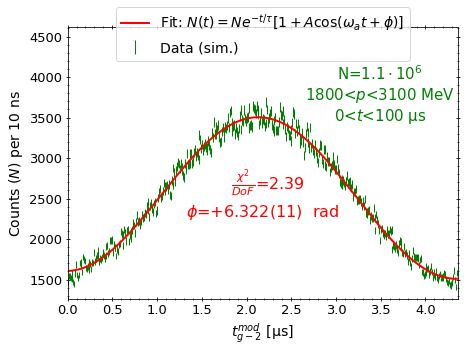

In [7]:
fig, ax = cu.plot(bin_c, freq, y_err=y_err, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]", ylabel=r"Counts ($N$) per "+str(int(bin_w*1e3))+" ns")
ax.plot(bin_c, cu.unblinded_wiggle_fixed(bin_c, *par), c="red", 
        label=r'Fit: $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(np.amin(freq)*0.9, np.amax(freq)*1.25);
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$\phi$", par[-1], par_e[-1], " rad", prec=3)
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(t_min)+r"<$t$<"+str(t_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.5, 0.35, leg_fit, c="r", fs=font_size+2)
cu.textL(ax, 0.8, 0.75, leg_data, fs=font_size+1)
fig.savefig("../fig/bnl_fit.png", dpi=300)

### Set constant phase for the next step

In [8]:
cu._LT=par[1]
print("LT set to", round(cu._LT,2), "us")
cu._phi=par[3]
print("Phase set to", round(cu._phi,2), "rad")

LT set to 70.58 us
Phase set to 6.32 rad


### Profile the $\langle\theta_y\rangle$, fit and plot (UNBLINDED simulation only)

In [9]:
df_binned =cu.Profile(mod_times, theta_y_mrad, None, nbins=bin_n, xmin=np.min(mod_times), xmax=np.max(mod_times), mean=True, only_binned=True)
x, y, y_e, x_e =df_binned['bincenters'], df_binned['ymean'], df_binned['yerr'], df_binned['xerr']

In [10]:
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_unblinded_phase, p0_theta_truth)

Params: [-0.038  0.139  0.041]
Errors: [0.018 0.017 0.013]
𝝌2/dof=1.07


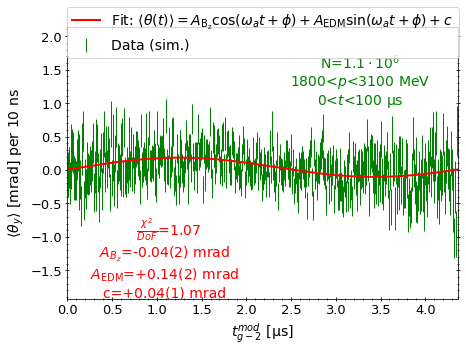

In [11]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad] per "+str(int(bin_w*1e3))+" ns")
ax.plot(x, cu.thetaY_unblinded_phase(x, *par), c="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)
ax.set_xlim(0, g2period);
ax.set_ylim(-np.amax(y)*1.8, np.amax(y)*2.0);
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(t_min)+r"<$t$<"+str(t_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.75, 0.8, leg_data, fs=font_size)
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$A_{B_{z}}$", par[0], par_e[0], "mrad")
leg_fit=cu.legend_1par(leg_fit, r"$A_{\mathrm{EDM}}$", par[1], par_e[1], "mrad")
leg_fit=cu.legend_1par(leg_fit, "c", par[2], par_e[2], "mrad")
cu.textL(ax, 0.25, 0.12, leg_fit, fs=font_size, c="r")
fig.savefig("../fig/bz_fit.png", dpi=300)

## Now do the EDM blinding via a convolution

### If simulation, make truth plots

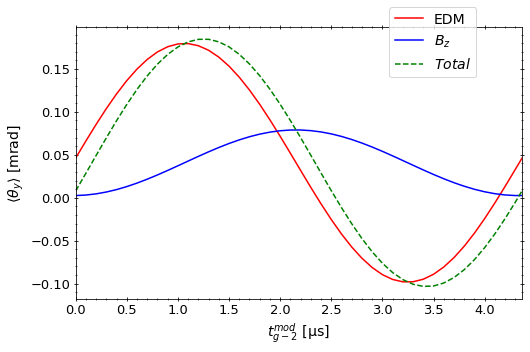

In [12]:
### Only for simulation truth plotting (!!!!)
A_bz,A_edm,c = par[0], par[1], par[2]
time_points = np.arange(0.0, g2period+0.1, 0.1) 
edm_truth=cu.sin(time_points, A_edm, omega_a, cu._phi, c)
bz_truth=cu.cos(time_points, A_bz, omega_a, cu._phi, c)
total_truth=cu.thetaY_unblinded_phase(time_points, A_bz, A_edm, c)
fig, ax= cu.plot(None, None, xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad]", tight=False, figsize=(8,5))
ax.plot(time_points, edm_truth, 'r-', label=r"EDM")
ax.plot(time_points, bz_truth, 'b-', label=r"$B_z$")
ax.plot(time_points, total_truth, 'g--', label=r"$Total$")
ax.set_xlim(0, g2period);
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.8, 1.1));
fig.savefig("../fig/truth_fit.png", dpi=300)

# Apply blinding

In [40]:
abs_mod_times, edm_weights = cu.get_abs_times_weights(t)

In [45]:
import ROOT as r
from ROOT import TFile, TStyle,TCanvas, gStyle, TF1, TH2F, gROOT, TMath, TLegend
# r.gROOT.Macro("~/rootlogon.C") 

In [49]:
hitAngleModRefl = TH2F("hitAngleModRefl", ";Time % #omega_{a} g2period [us];Angle [mrad]", 2000, 0, g2period, 1000, -1.6, 1.6)

Warning in <TROOT::Append>: Replacing existing TH1: hitAngleModRefl (Potential memory leak).


In [ ]:
ang=data['theta_y_mrad']
tMod=cu.get_edm_mod_times()

In [ ]:
if (tMod > 0) hitAngleModRefl->Fill(tMod, ang, weight);
else         hitAngleModRefl->Fill(-tMod, ang, weight);

In [36]:
# weights TODO check correct method
#normed : bool, optional
#An alias for the density argument that behaves identically. To avoid confusion with the broken normed argument to histogram, density should be preferred.
#weights : array_like, shape(N,), optional
#An array of values w_i weighing each sample (x_i, y_i). Weights are normalized to 1 if normed is True. If normed is False, the values of the returned histogram are equal to the sum of the weights belonging to the samples falling into each bin.

# xy_range=[ [0, g2period], [-50, 50] ]
xy_bins=(2000, 2000)
H, xedges, yedges = np.histogram2d(abs_mod_times, theta_y_mrad, bins=xy_bins, range=xy_range, weights=edm_weights, normed=False)

In [37]:
#### TODO more clever way 
# https://github.com/scikit-hep/histbook (weights)
# https://stackoverflow.com/questions/27156381/python-creating-a-2d-histogram-from-a-numpy-matrix
# Gooole profile with weights python
# Add weights to Profile function 
# histgrom2D -> ? -> Profile 

D=len(H.shape)
edges=[xedges, yedges]
freq=H

# prepare storage based on D dimensions (X,Y) 
data=[[], []]  
# X, Y values will be appended  
n_bins=[]
dBin=[] 
binC=[] 

freq=freq.astype(int, copy=False)

# loop over dimensions and fill bin centres
for i_dim in range(D):

    #extract the edges from the array of arrays

    edges_D=edges[i_dim]

    #find number of bins
    n_bins_D=len(edges_D)-1 # 1 more edge than bin centres 
    n_bins.append(n_bins_D)

    #find the bin width 
    dBin_D=edges_D[1]-edges_D[0]
    dBin.append(dBin_D)

    #array of bin centres
    binC_D=np.linspace(edges_D[0]+dBin_D/2, edges_D[-1]-dBin_D/2, n_bins_D)
    binC.append(binC_D)

# # now correlate binC(x,y) and freq(x,y)
for ix,iy in np.ndindex(freq.shape): # looping over x,y indices of a matrix 
    for i in range(0, freq[ix][iy]): # for that number of freq 
            data[0].append(binC[0][ix]) #append to  X, and Y
            data[1].append(binC[1][iy])
                
       

In [38]:
df_binned =cu.Profile(data[0], data[1], None, nbins=bin_n, xmin=0, xmax=g2period, mean=True, only_binned=True)
x, y, y_e, x_e =df_binned['bincenters'], df_binned['ymean'], df_binned['yerr'], df_binned['xerr']
df_binned

,index,bincenters,ymean,xerr,yerr
0,1,0.004995,-0.128825,0.004995,0.376497
1,2,0.014984,-0.373720,0.004995,0.407798
2,3,0.024973,0.318149,0.004995,0.362187
3,4,0.034963,0.296671,0.004995,0.377777
4,5,0.044952,0.042488,0.004995,0.358913
...,...,...,...,...,...
432,433,4.320372,-0.447300,0.004995,0.393450
433,434,4.330361,1.186477,0.004995,0.417222
434,435,4.340351,0.170402,0.004995,0.373479
435,436,4.350340,-0.007050,0.004995,0.377010


In [39]:
par, par_e, chi2_ndf = cu.fit_and_chi2(x, y, y_e, cu.thetaY_unblinded_phase, (-0.04, 0.0, 0.04))
N=np.sum(H)

Params: [-0.017  0.103  0.009]
Errors: [0.022 0.02  0.015]
𝝌2/dof=1.26


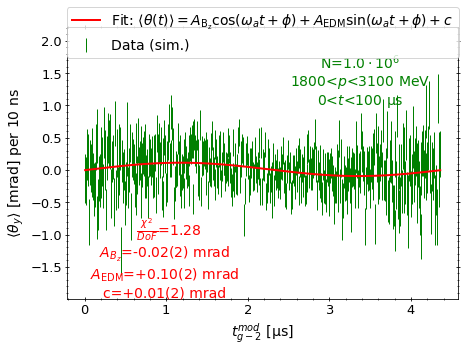

In [31]:
fig, ax = cu.plot(x, y, y_err=y_e, error=True, elw=1, label="Data (sim.)", fs=font_size, tight=False,
                  xlabel=r"$t^{mod}_{g-2} \ \mathrm{[\mu}$s]",  ylabel=r"$\langle\theta_y\rangle$ [mrad] per "+str(int(bin_w*1e3))+" ns")
ax.plot(x, cu.thetaY_unblinded_phase(x, *par), c="red", 
        label=r'Fit: $\langle \theta(t) \rangle =  A_{\mathrm{B_z}}\cos(\omega_a t + \phi) + A_{\mathrm{EDM}}\sin(\omega_a t + \phi) + c$', lw=2)
# ax.set_xlim(0, g2period);
ax.set_ylim(-np.amax(y)*1.8, np.amax(y)*2.0);
leg_data="N="+cu.sci_notation(N)+"\n"+str(p_min)+r"<$p$<"+str(p_max)+" MeV\n"+str(t_min)+r"<$t$<"+str(t_max)+r" $\mathrm{\mu}$s"
ax.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, 1.1));
cu.textL(ax, 0.75, 0.8, leg_data, fs=font_size)
leg_fit=cu.legend1_fit(chi2_ndf)
leg_fit=cu.legend_1par(leg_fit, r"$A_{B_{z}}$", par[0], par_e[0], "mrad")
leg_fit=cu.legend_1par(leg_fit, r"$A_{\mathrm{EDM}}$", par[1], par_e[1], "mrad")
leg_fit=cu.legend_1par(leg_fit, "c", par[2], par_e[2], "mrad")
cu.textL(ax, 0.25, 0.12, leg_fit, fs=font_size, c="r")
fig.savefig("../fig/bz_blind_fit.png", dpi=300)